In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt 
import os
import tqdm
import time
import spectrum

from sklearn.decomposition import PCA
from sklearn import svm

import warnings
warnings.filterwarnings("ignore")

## process training datasets => flatten 

In [2]:
BASE_DIR= "data/数据挖掘题目/近红外试题1/"
TRAINING_DIR= os.path.join(BASE_DIR, "建模集光谱")
chemical_excel = os.path.join(BASE_DIR, "建模集化学值.xlsx")
TEST_DIR= "验证集光谱"
SHEET_NAME="初始化学值"
TEST_DIR= os.path.join(BASE_DIR, "验证集光谱")

In [3]:
# add a helper func to read Excel file
def get_chemical_source(file_path: str, sheet_name=None)-> pd.DataFrame:
    chemical_data = pd.read_excel(file_path, sheet_name)
    return chemical_data
    
chemical_data = get_chemical_source(chemical_excel, "初始化学值")
chemical_data.tail(2)

,样本序号,产地,等级,实验室化学值
119,120,昆明,C1FA,2.09
120,121,昆明,C1FA,2.27


In [4]:
def flatten_speactrum(training_dir: str)-> pd.DataFrame:
    spectrum_data= list()
    file_number= list()
    
    for file in os.listdir(training_dir):
        try:
            data = (pd.read_csv(os.path.join(training_dir,file), \
                                header= None, \
                                float_precision='high', \
                                index_col= None))
            
            spectrum_data.append(data.iloc[:,1].values)
            file_number.append(file.split(".")[0])
            
        except Exception as e:
            print(str(e))
            pass 
        
    return pd.DataFrame({"file_number":file_number, "spectrum_data": spectrum_data}) 

In [5]:
flatten_speactrum(TRAINING_DIR)

Error tokenizing data. C error: Expected 1 fields in line 22, saw 139



,file_number,spectrum_data
0,021,"[0.0781635368863741, 0.0779269219686587, 0.077..."
1,035,"[0.0912279970943927, 0.0909563116729259, 0.090..."
2,009,"[0.0641413498669862, 0.0639781728386878, 0.063..."
3,008,"[0.0820071039100487, 0.0818481047948201, 0.081..."
4,034,"[0.0866247688730557, 0.0863164328038692, 0.086..."
...,...,...
116,005,"[0.0815359031160672, 0.0812451547632614, 0.081..."
117,011,"[0.0733681979278723, 0.0731230750679969, 0.072..."
118,010,"[0.0673237635443608, 0.0671361628919839, 0.067..."
119,004,"[0.0716337859630584, 0.0714217660327752, 0.071..."


In [6]:
def process_flatten_data(df_flatten, column_name):
    df_flatten["file_number"]= df_flatten.iloc[:, 0].apply(lambda x: int(x))
    df_flatten.rename(columns={"file_number":"样本序号"}, inplace= True)

    merged_df= chemical_data.merge(df_flatten, on="样本序号").rename(columns={"spectrum_data": "光谱数据"}) 
    return merged_df

In [7]:
merged_flatten_df= process_flatten_data(flatten_speactrum(TRAINING_DIR), "file_number")
merged_flatten_df.tail(2)

Error tokenizing data. C error: Expected 1 fields in line 22, saw 139



,样本序号,产地,等级,实验室化学值,光谱数据
119,120,昆明,C1FA,2.09,"[0.0950146988034248, 0.0947373708089192, 0.094..."
120,121,昆明,C1FA,2.27,"[0.0834100879728794, 0.0831408351659774, 0.082..."


In [8]:
# spectrum_display
def plot_spectrum(file):
    plt.figure(figsize=(8, 6), dpi=100)
    
    for i in range(len(file.index)):
        plt.xlabel("Wavelength") #波长
        plt.ylabel("Absorbance (AU)") #吸光度
        plt.plot(merged_flatten_df["光谱数据"][i])
        plt.grid(True)
        plt.tight_layout()

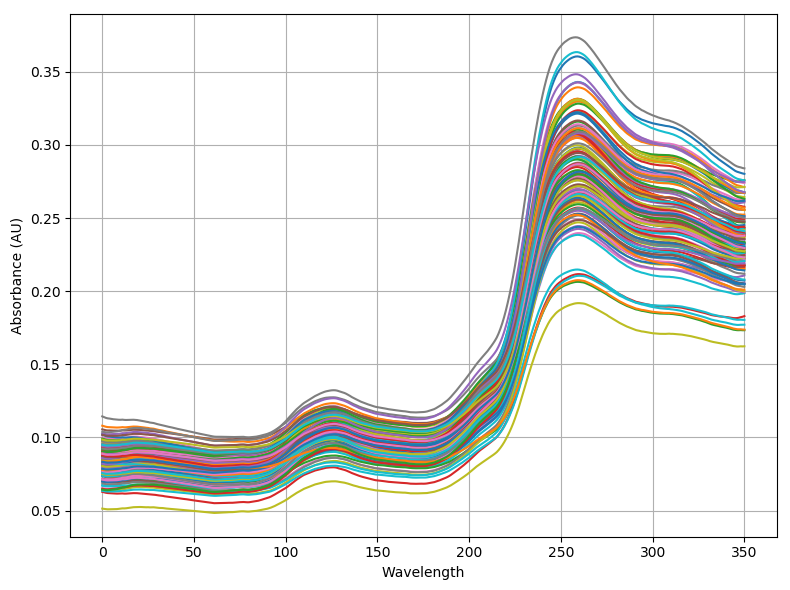

In [9]:
plot_spectrum(merged_flatten_df["光谱数据"])

#### Pre_processing - standardization
- normalisation, smoothing or derivatives were applied to its training data, as well as the spectrum range and sampling frequency of the training data.

In [10]:
from sklearn.preprocessing import StandardScaler

def standard_row(row):
    scaler = StandardScaler()
    return scaler.fit_transform(row.reshape(-1,1))

merged_flatten_df["标准化光谱数据"]= merged_flatten_df.loc[:,"光谱数据"].apply(lambda x: standard_row(x))
merged_flatten_df.tail(2)

,样本序号,产地,等级,实验室化学值,光谱数据,标准化光谱数据
119,120,昆明,C1FA,2.09,"[0.0950146988034248, 0.0947373708089192, 0.094...","[[-0.8582293126275177], [-0.8618566412920955],..."
120,121,昆明,C1FA,2.27,"[0.0834100879728794, 0.0831408351659774, 0.082...","[[-0.8726602228650411], [-0.8761571997562042],..."


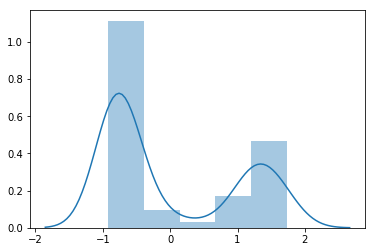

In [11]:
sns.distplot(merged_flatten_df["标准化光谱数据"][0])

## Baseline 
#### PCA to reduce dims then use classification model 

In [12]:
def flatten2row(training_dir: str)-> pd.DataFrame:
    spectrum_data= list()
    file_name = list()
    for file in os.listdir(training_dir):
        try:
            data = (pd.read_csv(os.path.join(training_dir,file), \
                                header= None, \
                                
                                index_col= None))
            
            spectrum_data.append(data.iloc[:,1].values)
            file_name.append(file.split(".")[0])
            
        except Exception as e:
            pass 
        
    return pd.DataFrame(spectrum_data), file_name

train_data, file_name= flatten2row(TRAINING_DIR)
test_data, _= flatten2row(TEST_DIR)

In [13]:
train_data.tail(2)

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
119,0.071634,0.071422,0.071270,0.071236,0.071371,0.071430,0.071513,0.071611,0.071696,0.071874,...,0.246091,0.245463,0.244783,0.244180,0.243700,0.243354,0.243215,0.243198,0.243009,0.242948
120,0.081169,0.080840,0.080564,0.080394,0.080425,0.080436,0.080454,0.080440,0.080440,0.080576,...,0.228991,0.228411,0.227786,0.227207,0.226744,0.226420,0.226296,0.226299,0.226163,0.226152


#### Find peak time of each spectrum, during certain frequency 

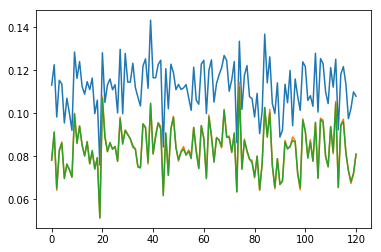

In [14]:
plt.plot(train_data[200])
plt.plot(train_data[0])
plt.plot(train_data[10])

In [15]:
train_data["样本序号"]= file_name
train_data["样本序号"]= train_data["样本序号"].apply(lambda x: int(x))
train_data.tail(2)

,0,1,2,3,4,5,6,7,8,9,...,342,343,344,345,346,347,348,349,350,样本序号
119,0.071634,0.071422,0.071270,0.071236,0.071371,0.071430,0.071513,0.071611,0.071696,0.071874,...,0.245463,0.244783,0.244180,0.243700,0.243354,0.243215,0.243198,0.243009,0.242948,4
120,0.081169,0.080840,0.080564,0.080394,0.080425,0.080436,0.080454,0.080440,0.080440,0.080576,...,0.228411,0.227786,0.227207,0.226744,0.226420,0.226296,0.226299,0.226163,0.226152,38


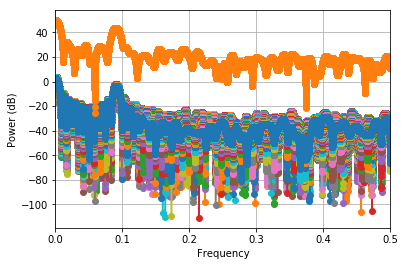

In [18]:
from spectrum import Periodogram, data_cosine

p = Periodogram(train_data)
p.plot(marker='o') 

In [17]:
merged_df= chemical_data.merge(train_data, on="样本序号", how= "left")
merged_df.tail(2)

,样本序号,产地,等级,实验室化学值,0,1,2,3,4,5,...,341,342,343,344,345,346,347,348,349,350
119,120,昆明,C1FA,2.09,0.095015,0.094737,0.094533,0.094470,0.094570,0.094572,...,0.244856,0.244202,0.243497,0.242908,0.242381,0.241953,0.241740,0.241627,0.241288,0.241072
120,121,昆明,C1FA,2.27,0.083410,0.083141,0.082913,0.082783,0.082821,0.082806,...,0.236340,0.235702,0.235034,0.234424,0.233902,0.233462,0.233204,0.233059,0.232714,0.232436


#### SVM 

In [19]:
from sklearn import svm

#task 1
cls = svm.SVC(kernel="linear")
#train the model
merged_df.dropna(inplace= True)
cls.fit(merged_df.iloc[:, 4:], merged_df["等级"])
#predict the response
pred = cls.predict(test_data)
pred

array(['B1F', 'B1F', 'C4F', 'C3F', 'B1F', 'C4F', 'C3F', 'C3F', 'C3F',
       'B1F', 'B1F', 'B1F', 'C3F', 'C3F', 'C4F', 'B1F', 'C4F', 'C4F',
       'C4F', 'C3F', 'C3F', 'C3F', 'C3F', 'B1F', 'B1F', 'C4F', 'C3F',
       'B1F', 'C3F', 'C4F'], dtype=object)

In [20]:
cls.fit(merged_df.iloc[:, 4:], merged_df["样本序号"])
#predict the response
pred_sample = cls.predict(test_data)
pred_sample

array([ 42,  68,  22,   8,  41,  88,  10,   8,  95,  51,  27,  62,   3,
        24, 101,  48,   7,  22,  14,   5,   5, 107, 114,  29,  51,  91,
       119,  43,  36, 105])

In [21]:
pca = PCA(n_components=100)
principalComponents = pd.DataFrame(pca.fit_transform(merged_df.iloc[:, 4:]))

#### KNN 

In [22]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=100)
neigh.fit(merged_df.iloc[:, 4:], merged_df.loc[:, "样本序号"])

KNeighborsClassifier(n_neighbors=100)

In [23]:
neigh.predict(test_data)

array([1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 2])

## Task 2

In [24]:
BASE_DIR_2= "data/数据挖掘题目/近红外试题2/"
TRAINING_DIR_2= os.path.join(BASE_DIR_2, "建模光谱/")
chemical_excel_2 = os.path.join(BASE_DIR_2, "建模化学值.xlsx")
TEST_DIR_2= "验证光谱/"
TEST_DIR_2= os.path.join(BASE_DIR_2, "验证光谱/")

In [25]:
chemical_data_2= pd.read_excel(chemical_excel_2)
chemical_data_2.tail(2)

,序号,名称,烟碱
544,545,20160926162825-甘肃X3F-5-19.dx,1.61
545,546,20160926162917-甘肃X3F-5-20.dx,1.58


In [26]:
chemical_data_2["sample_type"]= chemical_data_2["名称"].apply(lambda title: title.split(".")[0])

In [27]:
def get_data(train_dir):
    
    col1= list()
    col2= list()
    file_number= list()
    
    start = time.time()
    for file in os.listdir(train_dir):
        data= pd.read_csv(train_dir+ file, header=None, names=["col", "col2"])
        
        for i,k in data.loc[:, ["col","col2"]].values:
                col1.append(i)
                col2.append(k)
                file_number.append(file.split(".")[0])
                
    end = time.time() -start 
    print(f"process time costs {end}")
    
    return pd.DataFrame({"sample_type": file_number, "col":col1, "col2": col2}) 

In [28]:
train_data_2 = get_data(TRAINING_DIR_2)
train_data_2.tail(2)

process time costs 1.7386398315429688


,sample_type,col,col2
139774,20151109183901-江苏中烟B2F-H-5-1,11220.095640,0.3164
139775,20151109183901-江苏中烟B2F-H-5-1,11301.682595,0.3120


In [29]:
megered_df_2= train_data_2.merge(chemical_data_2.iloc[:, [2,3]], on="sample_type")
megered_df_2.tail(2)

,sample_type,col,col2,烟碱
139774,20151109183901-江苏中烟B2F-H-5-1,11220.095640,0.3164,4.66
139775,20151109183901-江苏中烟B2F-H-5-1,11301.682595,0.3120,4.66


In [30]:
megered_df_2["烟碱"] = megered_df_2["烟碱"].apply(lambda x: str(x))
megered_df_2["Y"]= megered_df_2[["sample_type","烟碱"]].apply(lambda x: '_'.join(x), axis=1)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=500)
model.fit(megered_df_2[["col", "col2"]],megered_df_2["Y"])

KNeighborsClassifier(n_neighbors=500)

In [32]:
predicted= model.predict([["4532.51627173342","0.5663"]]) 
print(predicted)

['20150827153107-红塔X3F-5-1_1.87']


In [33]:
test_data_2= get_data(TEST_DIR_2)
test_data_2.dropna(inplace= True)

process time costs 0.21895503997802734


In [34]:
try:
    test_data_2["pred_label"]= test_data_2[["col", "col2"]].apply(model.predict)
except Exception as e:
    print(e)
    pass 

could not convert string to float: '\x06'


In [35]:
# test_data_2[test_data_2["col"]=="\x06"]

In [36]:
predicated5= model.predict([["8205.73","0.2867"]])
predicated5

array(['20150827153107-红塔X3F-5-1_1.87'], dtype=object)

In [37]:
#encoding categorical labels 

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder() 
ohe.fit_transform(megered_df_2[["sample_type"]])

<139776x546 sparse matrix of type '<class 'numpy.float64'>'
	with 139776 stored elements in Compressed Sparse Row format>

#### use SVM for these all tasks
- after testing with PCA, which didn't generated good model result by random checking, not apply model inference yet by checking model accuracy using ground truth label. 

In [ ]:
# # for task2
# cls = svm.SVC(kernel="linear")
# cls.fit(megered_df_2.iloc[:, [1,2]], megered_df_2["烟碱"])
# #predict the tabacco
# pred_2= cls.predict(test_data_2.iloc[:, [1,2]])
# pred_2

In [38]:
BASE_DIR_3= "data/数据挖掘题目/近红外试题3/"
TRAINING_DIR_3= os.path.join(BASE_DIR_3, "建模集光谱/")
chemical_excel_3 = os.path.join(BASE_DIR_3, "建模集化学值.xlsx")
TEST_DIR_3= "验证集光谱/"
TEST_DIR_3= os.path.join(BASE_DIR_3, "验证集光谱/")

chemical_data_3= pd.read_excel(chemical_excel_3)[["Sample", "化学值"]]
chemical_data_3.tail(2)

chemical_data_3["样本序号"]= chemical_data_3["Sample"].apply(lambda x: int(x.split("-")[-1]))

df_flatten= flatten_speactrum(TRAINING_DIR_3)
df_flatten["file_number"]= df_flatten.iloc[:, 0].apply(lambda x: int(x))
df_flatten= df_flatten.rename(columns={"file_number": "样本序号"})
merged_df= chemical_data_3.merge(df_flatten, on="样本序号").rename(columns={"spectrum_data": "光谱数据"}) 
merged_df

,Sample,化学值,样本序号,光谱数据
0,云南德宏遮放基地化学样C3F(KRK26)-1,3.67,1,"[0.1858841131130854, 0.1857286517818768, 0.185..."
1,云南德宏遮放基地化学样C4F(KRK26)-2,1.90,2,"[0.1699766516685485, 0.1697309215863545, 0.169..."
2,云南德宏遮放基地化学样B2F(KRK26)-3,3.71,3,"[0.1746855303645134, 0.1745443393786748, 0.174..."
3,贵州铜仁松桃甘龙C3F云烟87-基地-9,3.38,9,"[0.1110393491884072, 0.1111088767647743, 0.111..."
4,贵州铜仁松桃甘龙B2F云烟87-基地-10,2.56,10,"[0.1151171115537484, 0.1150607553621133, 0.115..."
...,...,...,...,...
113,辽宁阜新阜蒙-0408-X3F-基地-148,1.10,148,"[0.122776976476113, 0.1226697961489359, 0.1225..."
114,辽宁阜新阜蒙-0408-B2F-基地-149,2.47,149,"[0.1421591838200887, 0.1419201418757438, 0.141..."
115,安徽芜湖南陵-云烟97-B2F-基地-150,3.00,150,"[0.1192158820728461, 0.1189887759586175, 0.118..."
116,安徽芜湖南陵-云烟97-C3F-基地-151,1.90,151,"[0.1240481026470661, 0.1239495339492956, 0.123..."


In [39]:
train_data3, file_name3= flatten2row(TRAINING_DIR_3)
test_data3, _= flatten2row(TEST_DIR_3)

In [40]:
train_data3.head(2)

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,0.138438,0.138370,0.138304,0.138269,0.138279,0.138265,0.138222,0.138288,0.138454,0.138497,...,0.258356,0.257519,0.256722,0.256068,0.255518,0.254963,0.254344,0.253891,0.253528,0.253090
1,0.131014,0.130811,0.130658,0.130528,0.130383,0.130229,0.130098,0.130076,0.130134,0.130093,...,0.230830,0.230280,0.229674,0.229191,0.228892,0.228581,0.228196,0.228009,0.227951,0.227817


In [41]:
train_data["样本序号"]= file_name
train_data["样本序号"]= train_data["样本序号"].apply(lambda x: int(x))
train_data.tail(2)

,0,1,2,3,4,5,6,7,8,9,...,342,343,344,345,346,347,348,349,350,样本序号
119,0.071634,0.071422,0.071270,0.071236,0.071371,0.071430,0.071513,0.071611,0.071696,0.071874,...,0.245463,0.244783,0.244180,0.243700,0.243354,0.243215,0.243198,0.243009,0.242948,4
120,0.081169,0.080840,0.080564,0.080394,0.080425,0.080436,0.080454,0.080440,0.080440,0.080576,...,0.228411,0.227786,0.227207,0.226744,0.226420,0.226296,0.226299,0.226163,0.226152,38


In [42]:
merged_df_3= chemical_data_3.merge(train_data, on="样本序号")

In [43]:
#task 3
cls = svm.SVC(kernel="linear")
#train the model
merged_df.dropna(inplace= True)
cls.fit(merged_df_3.iloc[:, 3:], merged_df_3["Sample"])
#predict the response
pred = cls.predict(test_data)
pred

array(['湖南郴州永兴云烟87-X2F-基地-42', '云南曲靖师宗彩云C1F-云烟97-基地-68',
       '湖南永州蓝山土市云烟87-C3F-基地-22', '云南大理剑川沙溪马凳红花大金元B2F-基地-106',
       '湖南郴州永兴云烟87-C3F-基地-41', '云南丽江玉龙黎明金庄云烟87-C1F-基地-88',
       '贵州铜仁松桃甘龙B2F云烟87-基地-10', '云南丽江玉龙黎明金庄云烟87-C3V-基地-95',
       '云南丽江玉龙黎明金庄云烟87-C3V-基地-95', '福建三明宁化翠碧一号X2F-基地-51',
       '贵州遵义汇川沙湾X2F-基地-111', '云南玉溪华宁元江通海B2F-K326-基地-62',
       '云南德宏遮放基地化学样B2F(KRK26)-3', '湖南永州蓝山土市云烟87-B2F-基地-24',
       '云南丽江玉龙黎明金庄云烟87-C3F-基地-90', '湖南郴州永兴云烟87-X2F-基地-42',
       '贵州铜仁印江合水C3L云烟87-基地-11', '湖南永州蓝山土市云烟87-C3F-基地-22',
       '贵州铜仁印江合水B3F云烟87-基地-14', '云南普洱宁洱云烟87-C3F-基地-79',
       '云南普洱宁洱云烟87-C3F-基地-79', '贵州遵义播州尚稽X2F-基地-107', '贵州遵义汇川沙湾B2F-基地-114',
       '贵州遵义汇川沙湾X2F-基地-111', '福建三明宁化翠碧一号X2F-基地-51',
       '云南丽江玉龙黎明金庄云烟87-C4F-基地-91', '贵州毕节大方-B3F-云烟87-基地-119',
       '湖南郴州宜章云烟87-B2F-基地-43', '湖南郴州桂阳流峰云烟87-X2F-基地-36',
       '云南大理剑川沙溪马凳红花大金元C3L-基地-105'], dtype=object)